Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data


## Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from pathlib import Path

data_path = Path('/content/drive/My Drive/melanoma_data/')
data_dir_train = data_path / 'Train'
data_dir_test = data_path / 'Test'

print(data_dir_train)  # Output: /content/drive/My Drive/melanoma_data/Train
print(data_dir_test)   # Output: /content/drive/My Drive/melanoma_data/Test


/content/drive/My Drive/melanoma_data/Train
/content/drive/My Drive/melanoma_data/Test


In [5]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


# Load using keras.preprocessing
#  Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [6]:

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [7]:

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:


## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Can confirm that all 9 classes are present - so data upload seems succesfull

## Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the dataset

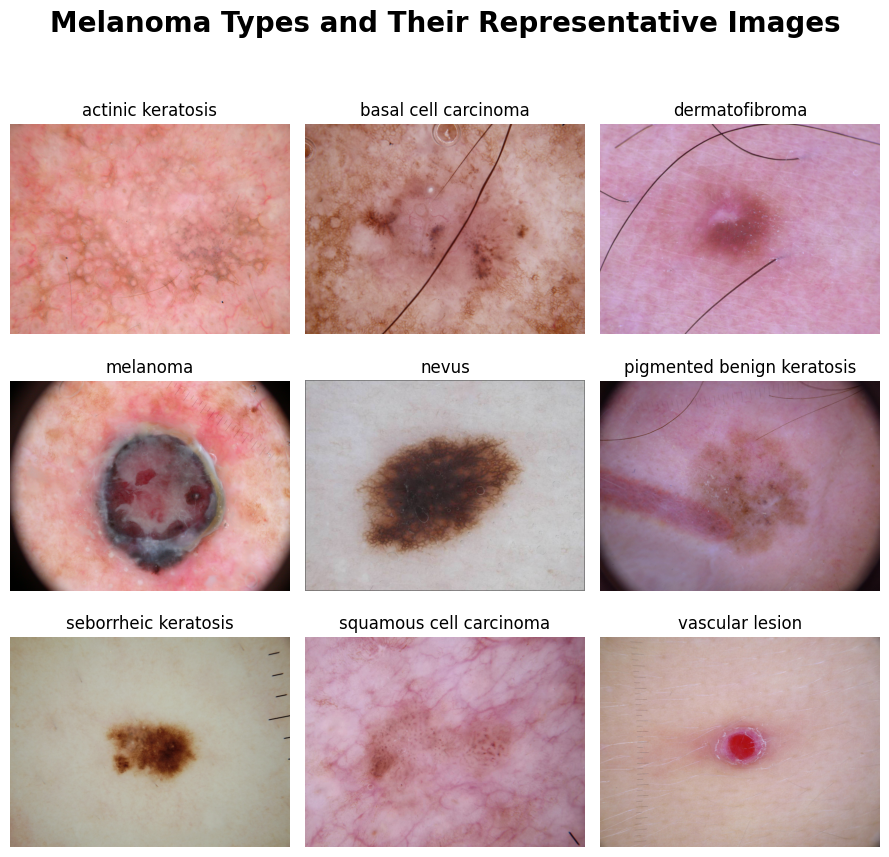

In [10]:
import matplotlib.pyplot as plt

# Plot dimensions
plt.figure(figsize=(9, 9))

# Add a heading at the top with spacing
plt.suptitle("Melanoma Types and Their Representative Images",
             fontsize=20, weight='bold', y=0.98)

# Loop through melanoma types and plot images
for melanoma_type in range(9):
    plt.subplot(3, 3, melanoma_type + 1)
    image = plt.imread(
        str(list(data_dir_train.glob(f'{class_names[melanoma_type]}/*.jpg'))[1]))
    plt.title(class_names[melanoma_type], fontsize=12)
    plt.imshow(image)
    plt.axis('off')

# Adjust the layout to prevent overlapping with the heading
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()



In [11]:
for image_batch, label_batch in train_ds.take(1):  # Inspect one batch from train_ds
    print("Image batch shape:", image_batch.shape)  # Expected: (32, 180, 180, 3)
    print("Label batch shape:", label_batch.shape)  # Expected: (32,)

for image_batch, label_batch in val_ds.take(1):  # Inspect one batch from val_ds
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)




Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)
Image batch shape: (23, 180, 180, 3)
Label batch shape: (23,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.



Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

num_classes = 9

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Faster optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)





/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model

Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)



In [15]:
# View the summary of all layers
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.2066 - loss: 2.3840 - val_accuracy: 0.0870 - val_loss: 2.5434
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.3662 - loss: 1.7643 - val_accuracy: 0.3043 - val_loss: 2.4899
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.4215 - loss: 1.5967 - val_accuracy: 0.2174 - val_loss: 2.7516
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.4821 - loss: 1.4803 - val_accuracy: 0.2174 - val_loss: 2.9783
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.5382 - loss: 1.3839 - val_accuracy: 0.2609 - val_loss: 2.6390
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.5102 - loss: 1.4015 - val_accuracy: 0.2609 - val_loss: 2.5775
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.5304 - loss: 1.3489 - val_accuracy: 0.2609 - val_loss: 2.0667
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.5295 - loss: 1.2841 - val_accuracy: 0.2609 - v

## Visualizing training results

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [17]:
#  Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
Findings After Model Fit
The model shows clear signs of overfitting, as it fails to generalize well to unseen data. This is evidenced by the significant disparity between training and validation performance.

Indicators of Overfitting:
1. Validation Accuracy Stagnates:
While training accuracy steadily improves, reaching ~71%, validation accuracy remains low (~26%), indicating poor generalization.

2. Validation Loss Increases:
Training loss consistently decreases, but validation loss increases over epochs, suggesting the model is overfitting the training data.


SyntaxError: invalid syntax (<ipython-input-17-d6c8f671de41>, line 2)

Write your findings here

In [21]:
print("Class Names:", class_names)

Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [23]:
import numpy as np




# List to store all labels
labels = []

# Iterate through the dataset to collect labels
for _, batch_labels in train_ds:
    labels.extend(batch_labels.numpy())

# Calculate class distribution
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Print class distribution
print("\nClass Distribution in Training Data:")
for class_name, count in zip(class_names, counts):
    print(f"{class_name}: {count}")

# Identify class with the least and most samples
min_class = class_names[np.argmin(counts)]
max_class = class_names[np.argmax(counts)]

print(f"\nClass with the least samples: {min_class} ({min(counts)} samples)")
print(f"Class with the most samples: {max_class} ({max(counts)} samples)")





Class Distribution in Training Data:
actinic keratosis: 92
basal cell carcinoma: 309
dermatofibroma: 77
melanoma: 352
nevus: 277
pigmented benign keratosis: 370
seborrheic keratosis: 58
squamous cell carcinoma: 142
vascular lesion: 115

Class with the least samples: seborrheic keratosis (58 samples)
Class with the most samples: pigmented benign keratosis (370 samples)


*italicized text*

### Findings on Class Distribution
#### 1. Class with the Least Number of Samples:

The class with the least number of samples is seborrheic keratosis, which has only 58 samples.
Dominant Classes:

#### 2. The class with the most samples is pigmented benign keratosis, with 370 samples.
Other highly represented classes include:
melanoma: 352 samples
basal cell carcinoma: 309 samples

##### 3. Observations:

There is significant class imbalance in the dataset, with some classes (e.g., seborrheic keratosis with 58 samples) being severely underrepresented compared to others (e.g., pigmented benign keratosis with 370 samples). This imbalance can lead the model to perform poorly on minority classes, as it may favor predicting the dominant classes.


In [25]:

!pip install Augmentor

In [29]:
path_to_training_dataset = "/content/drive/My Drive/melanoma_data/Train"


In [30]:
import Augmentor

for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    print(f"Processing class: {i}, Path: {class_path}")

    # Ensure the directory exists
    if not os.path.exists(class_path):
        print(f"Error: Directory {class_path} does not exist!")
        continue

    # Create augmentation pipeline
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Add 500 samples per class


Processing class: actinic keratosis, Path: /content/drive/My Drive/melanoma_data/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DAD31D0F970>: 100%|██████████| 500/500 [00:26<00:00, 19.11 Samples/s]


Processing class: basal cell carcinoma, Path: /content/drive/My Drive/melanoma_data/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DAD31DF6AA0>: 100%|██████████| 500/500 [00:27<00:00, 17.98 Samples/s]


Processing class: dermatofibroma, Path: /content/drive/My Drive/melanoma_data/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DAD3034F010>: 100%|██████████| 500/500 [00:26<00:00, 18.98 Samples/s]


Processing class: melanoma, Path: /content/drive/My Drive/melanoma_data/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DAD3036E1D0>: 100%|██████████| 500/500 [02:01<00:00,  4.10 Samples/s]


Processing class: nevus, Path: /content/drive/My Drive/melanoma_data/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DAD283BE860>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Processing class: pigmented benign keratosis, Path: /content/drive/My Drive/melanoma_data/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DAD2831FF40>: 100%|██████████| 500/500 [00:27<00:00, 18.46 Samples/s]


Processing class: seborrheic keratosis, Path: /content/drive/My Drive/melanoma_data/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DAD284E30A0>: 100%|██████████| 500/500 [00:53<00:00,  9.28 Samples/s]


Processing class: squamous cell carcinoma, Path: /content/drive/My Drive/melanoma_data/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DAD28378CD0>: 100%|██████████| 500/500 [00:24<00:00, 20.12 Samples/s]


Processing class: vascular lesion, Path: /content/drive/My Drive/melanoma_data/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/melanoma_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DAD3034E650>: 100%|██████████| 500/500 [00:27<00:00, 18.16 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
import os
from glob import glob

# Assuming `data_dir_train` is already defined
path_list = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
print(path_list)


['/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010299.jpg_3f6b5d74-6a5c-4909-b697-28e8a9bc9b6e.jpg', '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0009992.jpg_1bd54188-94e7-4e9c-a0ac-ba94cf958082.jpg', '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010533.jpg_08e3f084-61e6-403c-a84a-61d0e908767e.jpg', '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010579.jpg_a06c5e69-43a3-4126-8670-c8449fbbacda.jpg', '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010265.jpg_68363be5-fd76-4e8e-b7cd-6022519a5e1f.jpg', '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0010591.jpg_e56641c0-1e4d-4c65-9e6c-061e8aa70617.jpg', '/content/drive/My Drive/melanoma_data/Train/melanoma/output/melanoma_original_ISIC_0011181.jpg_f5db31af-fbd0-4b8f-b68e-437b5e3f44ab.jpg', '/content/drive/My Drive/m

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [36]:
from glob import glob
import os

# Assuming data_dir_train is already defined
path_list_new = glob(os.path.join(data_dir_train, '*', '*.jpg'))
print(f"Number of image paths: {len(path_list_new)}")


Number of image paths: 2239


In [38]:
import os
from glob import glob
import pandas as pd

# Assuming data_dir_train is already defined
path_list_new = glob(os.path.join(data_dir_train, '*', '*.jpg'))
lesion_list_new = [os.path.basename(os.path.dirname(path)) for path in path_list_new]

# Create dictionary mapping paths to labels
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

# Verify the dictionary
print(f"Number of items in dictionary: {len(dataframe_dict_new)}")
print(list(dataframe_dict_new.items())[:5])  # Preview first 5 items


Number of items in dictionary: 2239
[('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000142.jpg', 'melanoma'), ('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000144.jpg', 'melanoma'), ('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000139.jpg', 'melanoma'), ('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000141.jpg', 'melanoma'), ('/content/drive/My Drive/melanoma_data/Train/melanoma/ISIC_0000143.jpg', 'melanoma')]


In [43]:
# Convert the dictionary into a DataFrame
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

print(df2.head())  # Verify the new DataFrame

# Define or initialize original DataFrame
original_df = pd.DataFrame(columns=['Path', 'Label'])  # Replace with your actual original DataFrame if it exists
new_df = pd.concat([original_df, df2], ignore_index=True)

new_df['Label'].value_counts()

# Define or initialize original DataFrame
original_df = pd.DataFrame(columns=['Path', 'Label'])  # Replace with your actual original DataFrame if it exists

# Combine the two DataFrames
new_df = pd.concat([original_df, df2], ignore_index=True)
print(new_df.head())  # Verify the combined DataFrame


                                                Path     Label
0  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
1  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
2  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
3  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
4  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
                                                Path     Label
0  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
1  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
2  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
3  /content/drive/My Drive/melanoma_data/Train/me...  melanoma
4  /content/drive/My Drive/melanoma_data/Train/me...  melanoma


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Todo: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

### Todo: Create a training dataset

In [50]:
data_dir_train = "/content/drive/My Drive/melanoma_data/Train"


# Ensure img_height, img_width, and batch_size are defined
img_height = 180  # Example value
img_width = 180   # Example value
batch_size = 32   # Example value

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",  # Correct parameter value for training data
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [52]:
import os

if not os.path.exists(data_dir_train):
    print(f"Error: Directory {data_dir_train} does not exist!")
else:
    print(f"Directory {data_dir_train} found!")



Directory /content/drive/My Drive/melanoma_data/Train found!


### Todo: Create a validation dataset

In [54]:
val_ds= tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Todo: Create your model (make sure to include normalization)

In [55]:
## your code goes here
import tensorflow as tf
from tensorflow.keras import layers, Sequential

num_classes = len(class_names)  # Number of classes in your dataset

model = Sequential([
    # Normalization Layer
    layers.Rescaling(1.0 / 255, input_shape=(180, 180, 3)),

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Flatten the feature maps and add Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Increased dropout for better regularization
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Final output layer
])

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Print the Summary of the Model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       7,930,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,876,873 (33.86 MB)

 Trainable params: 8,876,873 (33.86 MB)

 Non-trainable params: 0 (0.00 B)

### Todo: Compile your model (Choose optimizer and loss function appropriately)

In [56]:

## your code goes here
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define learning rate reduction strategy
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss for improvements
    patience=4,          # Wait for 4 epochs before reducing learning rate
    factor=0.3,          # Reduce learning rate by a factor of 0.3
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print learning rate reduction messages
)

# Define optimizer
optimizer = Adam(learning_rate=0.001)  # Start with a learning rate of 0.001

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Suitable for multi-class classification
    metrics=['accuracy']
)



## Todo: Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.

# Train the model
history = model.fit(
    train_ds,                # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs,           # Number of epochs
    callbacks=[lr_scheduler] # Learning rate scheduler defined during compilation
)



Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1015s 6s/step - accuracy: 0.1746 - loss: 2.1321 - val_accuracy: 0.3344 - val_loss: 1.8050 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 987s 6s/step - accuracy: 0.3192 - loss: 1.7637 - val_accuracy: 0.3431 - val_loss: 1.7161 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1039s 6s/step - accuracy: 0.3423 - loss: 1.7046 - val_accuracy: 0.3871 - val_loss: 1.6322 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1043s 6s/step - accuracy: 0.4014 - loss: 1.5748 - val_accuracy: 0.4518 - val_loss: 1.4181 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1059s 6s/step - accuracy: 0.4298 - loss: 1.4854 - val_accuracy: 0.4627 - val_loss: 1.4058 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4461 - loss: 1.4408

### Todo: Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

In [25]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.1)  # Adjust brightness
])


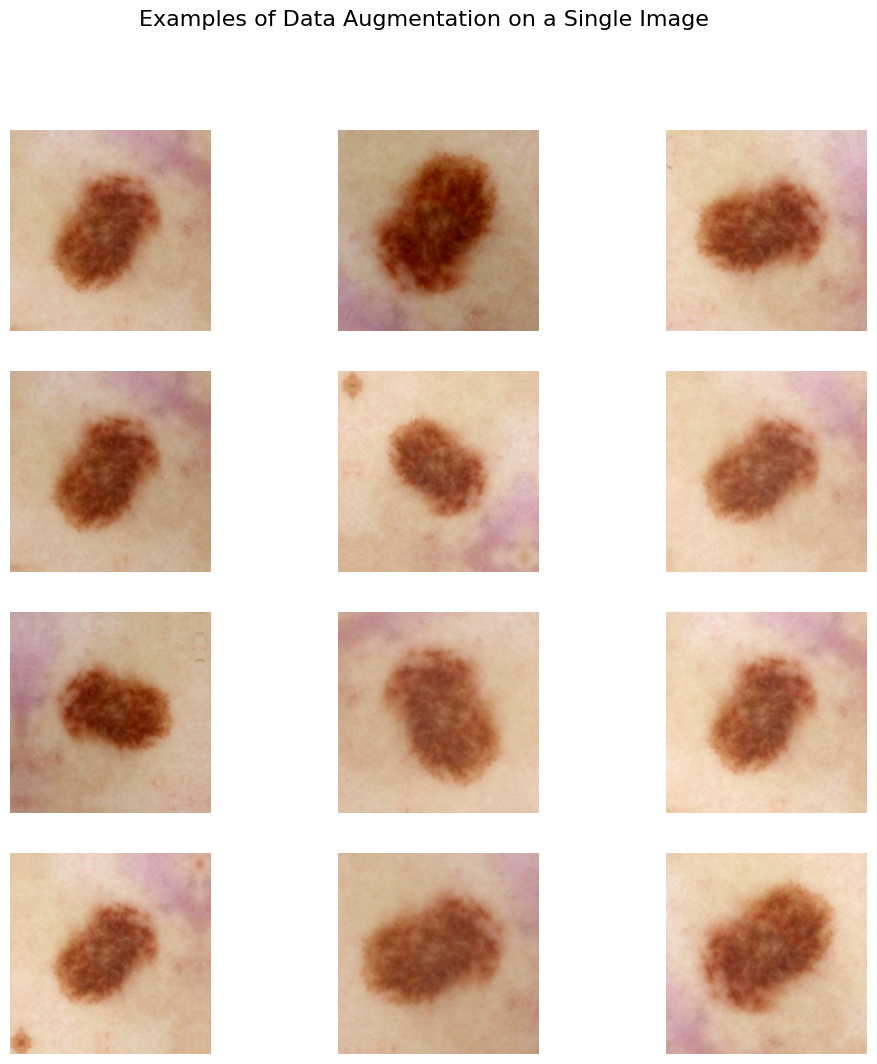

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

# Select a single image for augmentation
for images, labels in train_ds.take(1):  # Take one batch from training dataset
    sample_image = images[0]  # Use the first image in the batch

# Create a grid for augmented images
plt.figure(figsize=(12, 12))
for i in range(12):  # Generate 12 augmentations for better variety
    ax = plt.subplot(4, 3, i + 1)  # Create a 4x3 grid
    augmented_image = data_augmentation(tf.expand_dims(sample_image, axis=0))  # Add batch dimension
    plt.imshow(augmented_image[0].numpy().astype("uint8"))  # Visualize augmented image
    plt.axis("off")
plt.suptitle("Examples of Data Augmentation on a Single Image", fontsize=16)
plt.show()



Todo:

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


Mounted at /content/drive


## Create the model, compile and train the model